**PROJECT BACKGROUND**

Ulfita sedang belajar statistik ingin menganalisis dataset asuransi kesehatan. Dengan menganalisis dataset ini, ulfita dapat mengidentifikasi variabel-variabel yang paling berpengaruh pada biaya klaim kesehatan, serta meningkatkan akurasi model prediksi biaya klaim kesehatan. 

**Define The Problems:**
1. Variabel manakah pada data yang mempunyai pengaruh terhadap tagihan kesehatan?
2. Apakah variabel age mempunyai hubungan yang kuat dengan tagihan kesehatan?
3. Apakah variabel children mempunyai hubungan yang kuat dengan tagihan kesehatan?
4. Apakah variabel bmi mempunyai hubungan yang kuat dengan tagihan kesehatan?
5. Bagaimana kesimpulan akhirnya ? dan rekomendasi apakah yang dapat dilakukan?

Import Modul yang dibutuhkan

In [15]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

#Import the module for the linear regression model
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

plt.style.use('bmh')
sns.set()

In [18]:
# Load dataset
insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**DATA CLEANING**

In [19]:
insurance.shape

(1338, 7)

Pada dataset asuransi terdapat 1338 baris dan 7 kolom

In [20]:
# Melihat info dataset
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


berdasarkan info bisa kita lihat tidak terdapat missing value pada dataset



In [21]:
# Cek duplikat
insurance[insurance.duplicated(keep = "first")]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Terdapat data yang terduplikat pada dataset

In [22]:
# mengahpus data duplikat 
insurance.drop_duplicates(keep = "first", inplace = True)

# cek kembali apakah masih ada data yang terduplikat 
insurance.duplicated().any()

False

Data duplikat telah dihapus

HANDLING OUTLIER

In [24]:
# Menhadle outlier
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile
    low_limit = quartile1 - 1.5 * interquartile
    return low_limit, up_limit

In [25]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [26]:
for col in columns_:
    print(col, check_outlier(insurance, col))

age False
bmi True
charges True
children False


Terdapat outlier pada kbmi dan charges

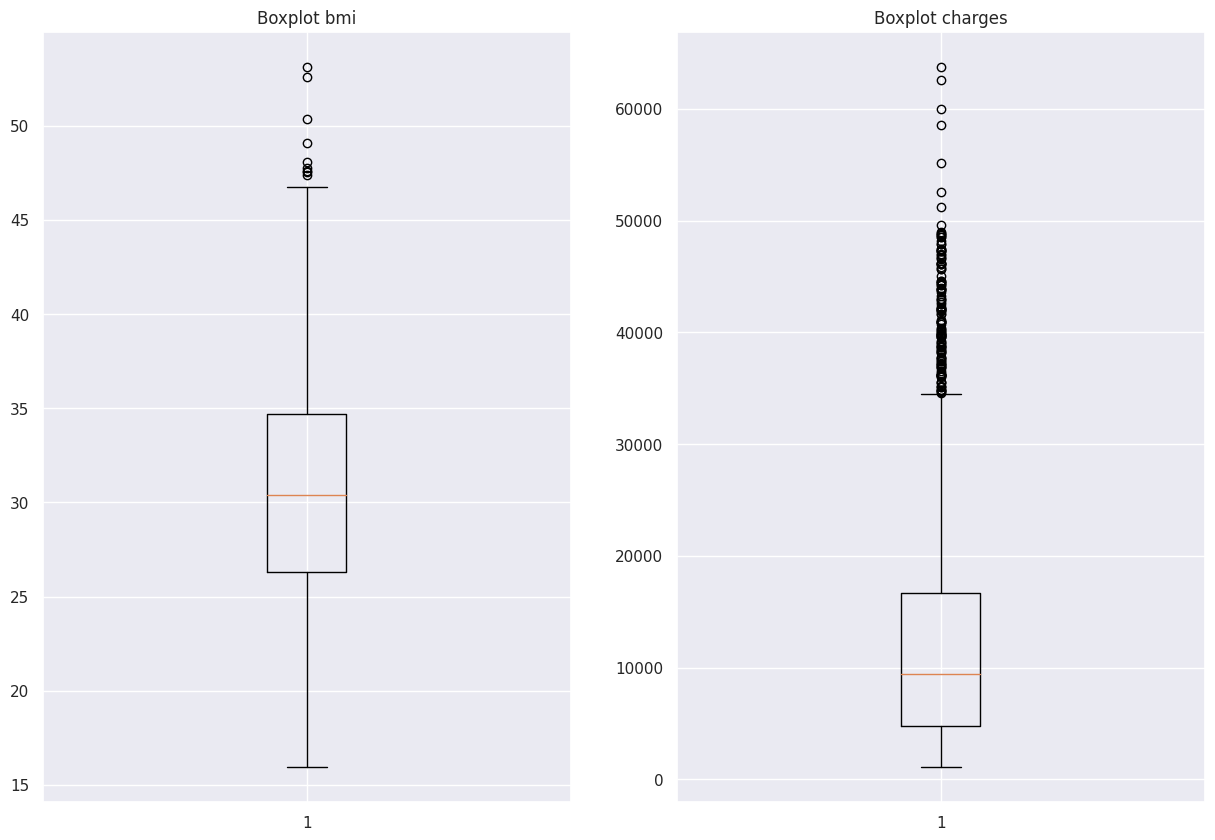

In [28]:
# Melihat outlier dengan boxplot
columns_ = ["bmi", "charges"]
index_ = 0
fig, ax = plt.subplots(1,2, figsize = (15,10)) 
for row in range(1):
    for col in range(2):
        ax[col].boxplot(insurance[columns_[index_]])
        ax[col].set_title(f"Boxplot {columns_[index_]}")
        index_ += 1
plt.show()

In [29]:
# Menghilangkan outlier
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [30]:
for col in columns_:
    replace_with_thresholds(insurance, col)

In [31]:
# cek kembali apakah outlier berhasil dihilangkan
for col in columns_:
    print(col, check_outlier(insurance, col))

bmi False
charges False


Outlier sudah dihilangkan

**MENGUBAH TIPE DATA**

In [32]:
# Mengubah tipe data.
dict_ = {"sex" : "category", "smoker" : "category", "region" : "category"}
insurance = insurance.astype(dict_) # mengubah tipe data dengan ketentuan pada dictionary yang telah dibuat.
insurance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1337 non-null   int64   
 1   sex       1337 non-null   category
 2   bmi       1337 non-null   float64 
 3   children  1337 non-null   int64   
 4   smoker    1337 non-null   category
 5   region    1337 non-null   category
 6   charges   1337 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 56.6 KB


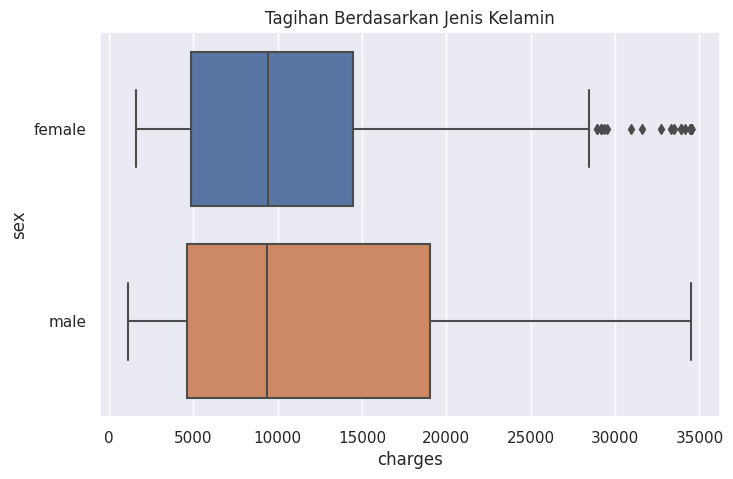

In [33]:
# Distribusi dari charges berdasarkan sex dengan menggunakan boxplot.
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x = "charges", y = "sex", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Jenis Kelamin")
plt.show()

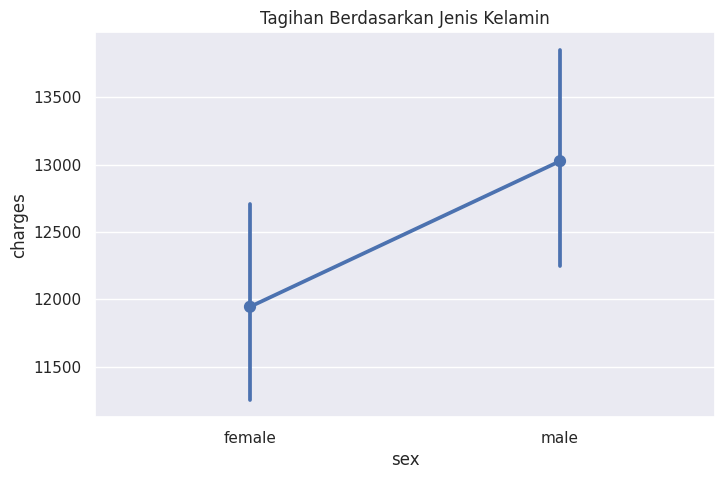

In [34]:
# Kode di bawah bertujuan untuk melihat tagihan berdasarkan kategori jenis kelamin dengan menggunakan point plot.
fig, ax = plt.subplots(figsize = (8,5))
sns.pointplot(y = "charges", x = "sex", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Jenis Kelamin")
plt.show()

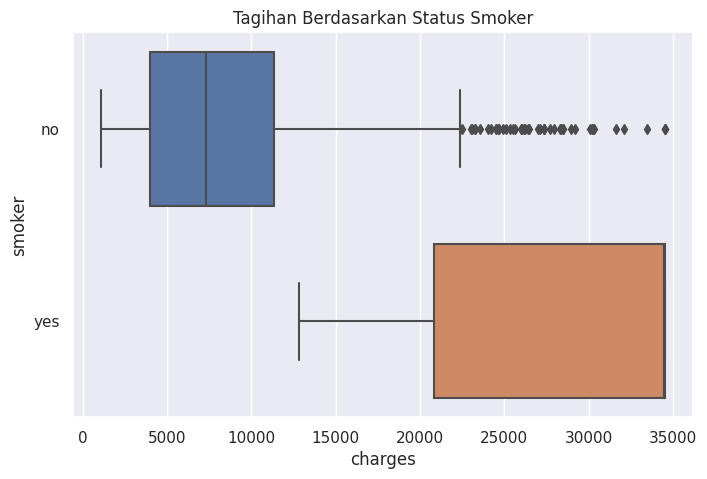

In [35]:
# Distribusi dari charges berdasarkan smoker dengan menggunakan boxplot
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x = "charges", y = "smoker", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Status Smoker")
plt.show()

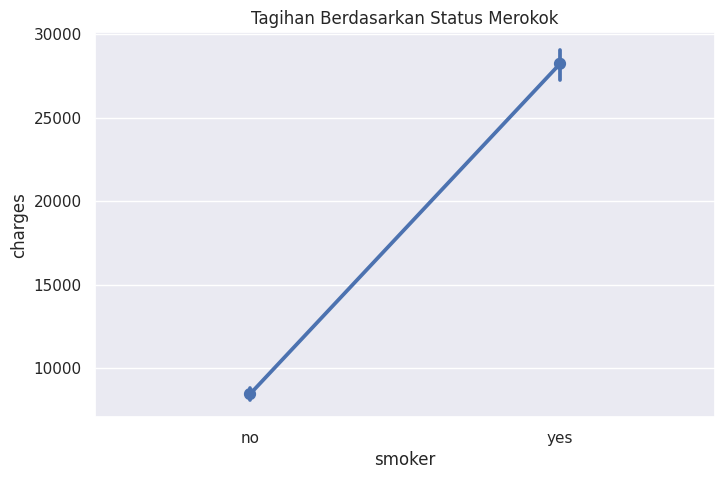

In [36]:
fig, ax = plt.subplots(figsize = (8,5))
sns.pointplot(y = "charges", x = "smoker", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Status Merokok")
plt.show()

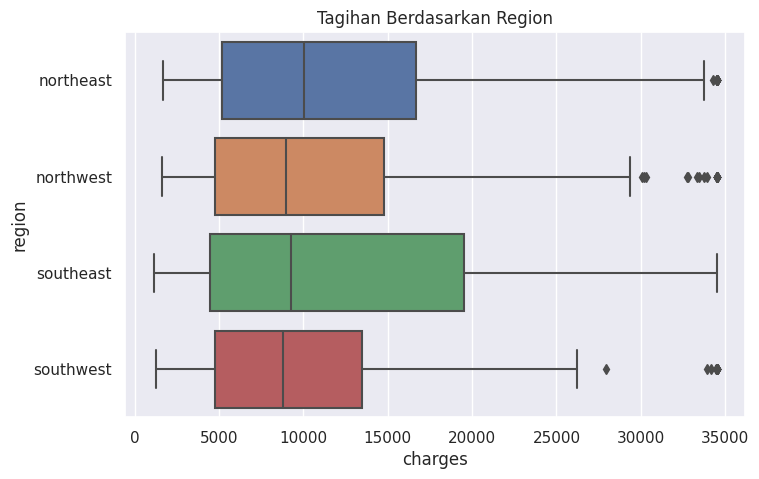

In [37]:
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x = "charges", y = "region", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Region")
plt.show()

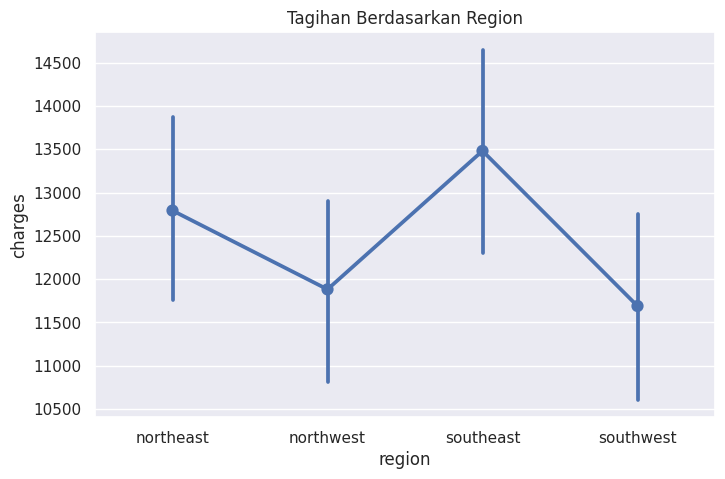

In [38]:
fig, ax = plt.subplots(figsize = (8,5))
sns.pointplot(y = "charges", x = "region", data = insurance, ax = ax)
ax.set_title("Tagihan Berdasarkan Region")
plt.show()

**Interaction**

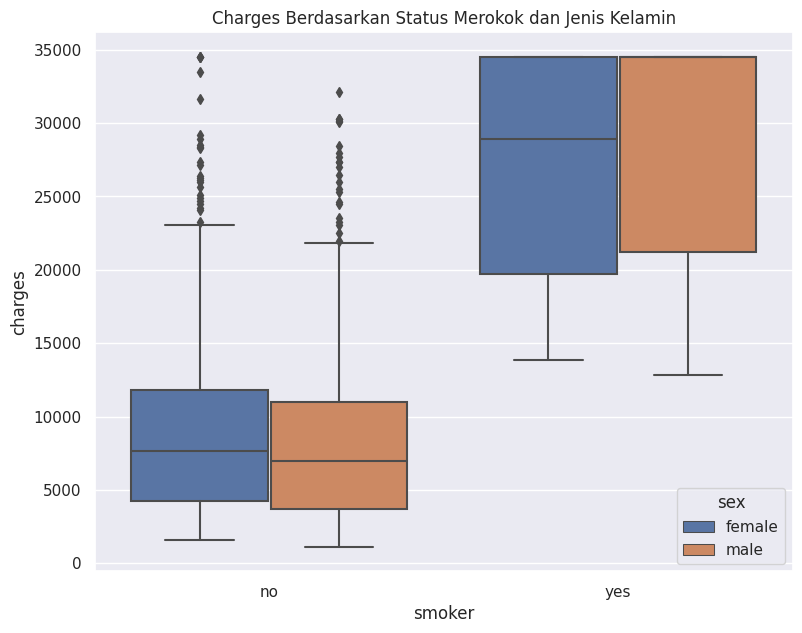

In [ ]:
# Kode di bawah bertujuan untuk melihat distribusi dari charges berdasarkan kategori sex dan kategori smoker dengan menggunakan boxplot.
fig, ax = plt.subplots(figsize = (9,7))
sns.boxplot(y = "charges", x =  "smoker",hue = 'sex', data = insurance, ax = ax)
ax.set_title("Charges Berdasarkan Status Merokok dan Jenis Kelamin")
plt.show()

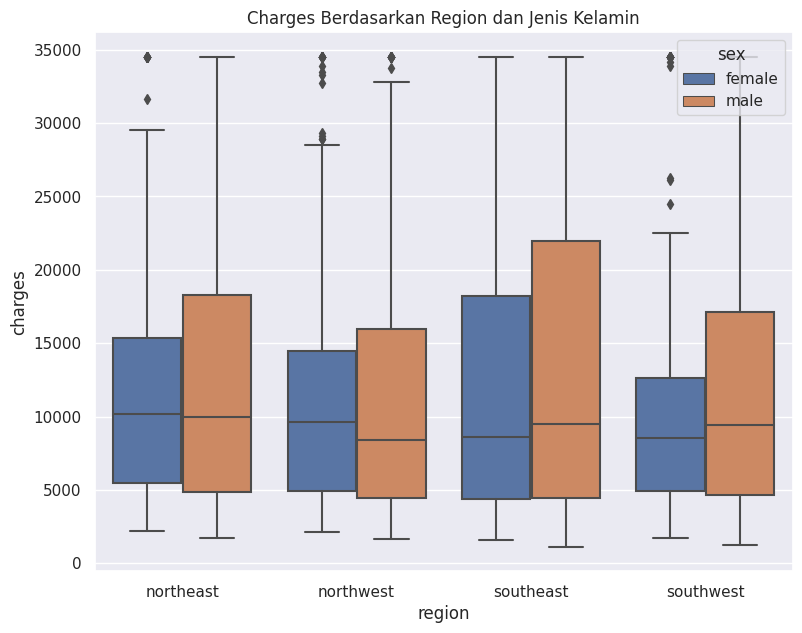

In [39]:
# Kode di bawah bertujuan untuk melihat distribusi dari charges berdasarkan kategori sex dan kategori region dengan menggunakan boxplot.
fig, ax = plt.subplots(figsize = (9,7))
sns.boxplot(y = "charges", x = "region",hue = 'sex', data = insurance, ax = ax)
ax.set_title("Charges Berdasarkan Region dan Jenis Kelamin")
plt.show()

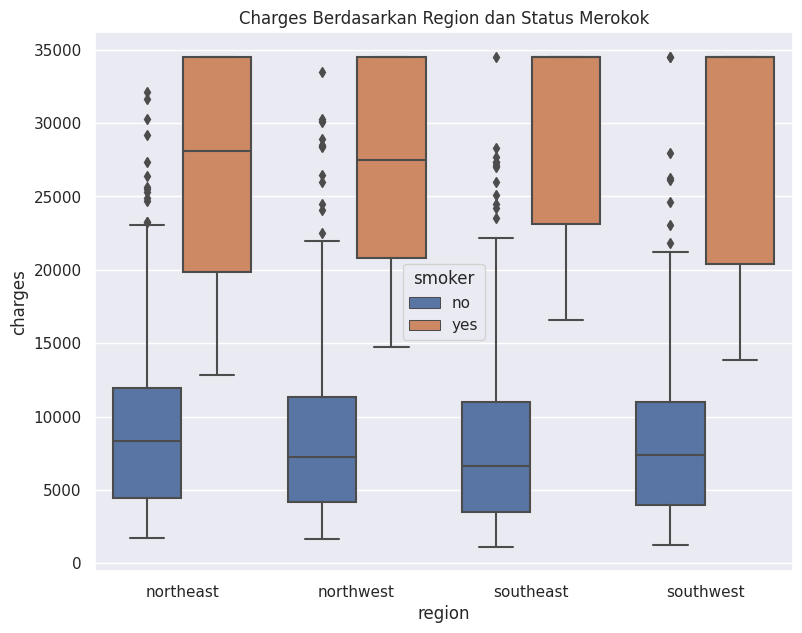

In [40]:
# Kode di bawah bertujuan untuk melihat distribusi dari charges berdasarkan kategori smoker dan kategori region dengan menggunakan boxplot.
fig, ax = plt.subplots(figsize = (9,7))
sns.boxplot(y = "charges", x = "region",hue = 'smoker', data = insurance, ax = ax)
ax.set_title("Charges Berdasarkan Region dan Status Merokok")
plt.show()

STATISTICAL TEST

In [41]:
# Import module
from scipy.stats import ttest_ind,levene,kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import normal_ad

In [43]:
female = insurance[insurance["sex"] == "female"]["charges"] 
male = insurance[insurance["sex"] == "male"]["charges"] 

n_male = male.shape[0] 
n_female = female.shape[0] 
result = ttest_ind(male, female, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk laki-laki = {n_male}')
print(f'Banyak sampel untuk perempuan = {n_female}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_laki-laki - mu_perempuan <= 0')
print('H1 : mu_laki-laki - mu_perempuan > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

if result[1] < 0.05:
  print("h0 ditolak")
else:
  print("gagal menolak h0")


Banyak sampel untuk laki-laki = 675
Banyak sampel untuk perempuan = 662
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_laki-laki - mu_perempuan <= 0
H1 : mu_laki-laki - mu_perempuan > 0
alpha = 0.05
Statistik Hitung = 1.9469552859555534
P Value = 0.025874786502641477
h0 ditolak


In [44]:
smoker = insurance[insurance["smoker"] == "yes"]["charges"] 
not_smoker = insurance[insurance["smoker"] == "no"]["charges"] 

n_smoker = smoker.shape[0] 
n_not_smoker = not_smoker.shape[0] 
result = ttest_ind(smoker, not_smoker, equal_var= False, random_state= 42, alternative= 'greater') # Melakukan uji t

print(f'Banyak sampel untuk kategori smoker = {n_smoker}')
print(f'Banyak sampel untuk kategori not smoker = {n_not_smoker}')
print('='*50)

print('Pertama. menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_smoker - mu_not_smoker <= 0')
print('H1 : mu_smoker - mu_not_smoker > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

if result[1] < 0.05:
  print("h0 ditolak")
else:
  print("gagal menolak h0")

Banyak sampel untuk kategori smoker = 274
Banyak sampel untuk kategori not smoker = 1063
Pertama. menyatakan hipotesis dan taraf signifikansi:
H0 : mu_smoker - mu_not_smoker <= 0
H1 : mu_smoker - mu_not_smoker > 0
alpha = 0.05
Statistik hitung = 41.02858880738608
P Value = 4.5809317248987785e-140
h0 ditolak


In [45]:
print("Pertama, menyatakan hipotesis dan taraf signifikansi :")
print("H0 : mu_northwest = mu_southwest = mu_southeast = mu_northeast")
print("H1 : Setidaknya terdapat satu yang berbeda")
print("Alpha = 0.05")

model_region = ols('charges ~ region', data = insurance).fit() # Membuat persamaan linear 
aov_table_1 = sm.stats.anova_lm(model_region) # Melakuakn uji ANOVA.

print("="*50)

print("Hasil dari Uji ANOVA :")
print(aov_table_1)
print("="*50)



Pertama, menyatakan hipotesis dan taraf signifikansi :
H0 : mu_northwest = mu_southwest = mu_southeast = mu_northeast
H1 : Setidaknya terdapat satu yang berbeda
Alpha = 0.05
Hasil dari Uji ANOVA :
              df        sum_sq       mean_sq         F    PR(>F)
region       3.0  7.153556e+08  2.384519e+08  2.314313  0.074244
Residual  1333.0  1.373437e+11  1.030336e+08       NaN       NaN


Karena hasil uji ANOVA menyatakan p-value > 0.05, maka keputusan yang diperoleh adalah gagal untuk menolak H0 yang dimana tidak adanya perbedaan rata - rata tagihan  yang signifkan dengan region yang berbeda-beda 

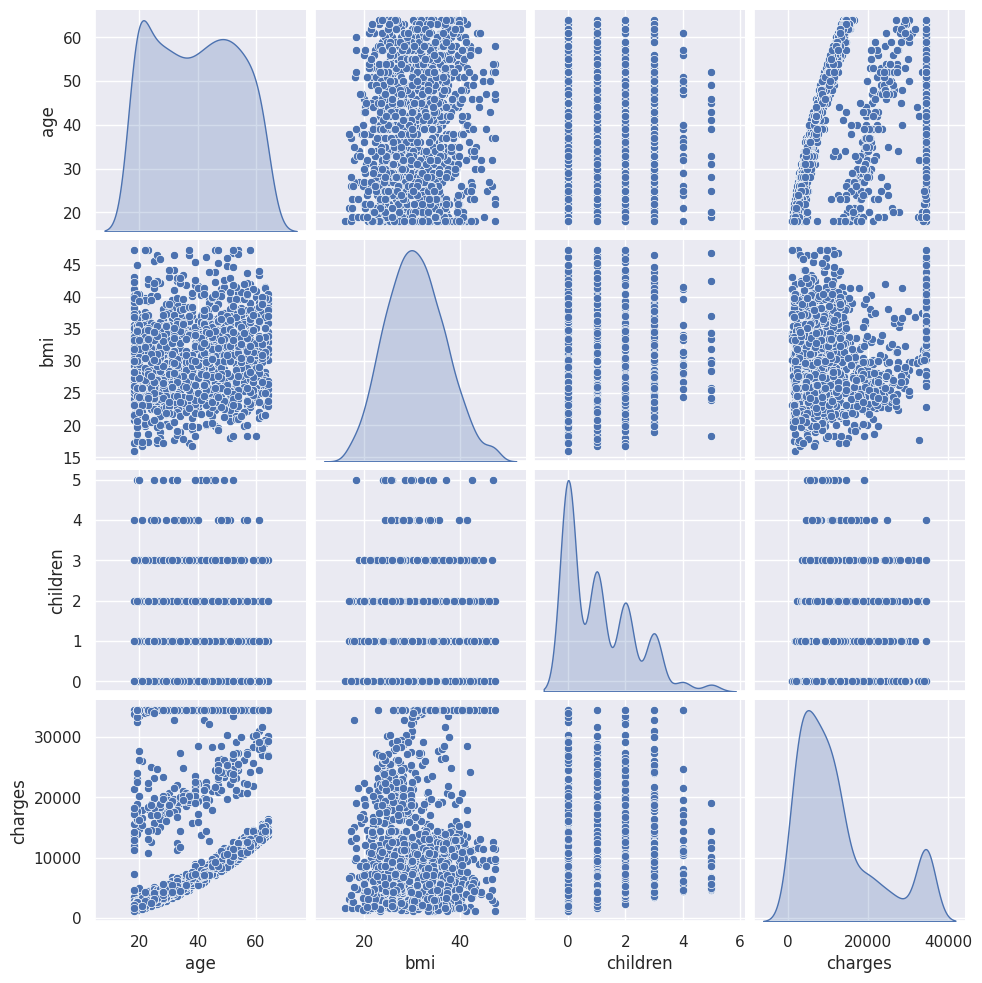

In [46]:
# Kode di bawah bertujuan untuk memvisualisasikan interaksi antara bebera features dengan meggunakan scatter plot dan kde plot.
columns_ = ["age","bmi","children","charges"]
sns.pairplot(insurance[columns_], diag_kind = 'kde')
plt.show()

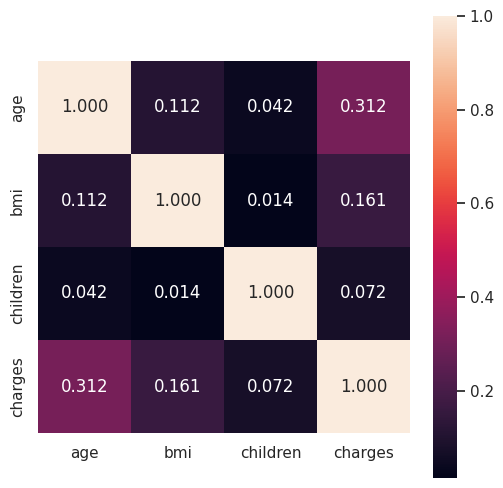

In [47]:
# Kode di bawah untuk melihat korelasi antar features.
columns_ = ["age","bmi","children","charges"]
corr_ = insurance[columns_].corr()
plt.figure(figsize = (6,6))
sns.heatmap(corr_, fmt= ".3f", annot= True,square= True)
plt.show()

Age dan bmi masih memiliki hubungan dengan charges

**Building Regression Model**



In [48]:
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [56]:
# Exclude variabel-variabel yang tidak memberikan efek signifikan terhadap tagihan
insurance2 = insurance.drop(['region', 'children', 'bmi'], axis=1)
insurance2

,age,sex,smoker,charges
0,19,female,yes,16884.92400
1,18,male,no,1725.55230
2,28,male,no,4449.46200
3,33,male,no,21984.47061
4,32,male,no,3866.85520
...,...,...,...,...
1333,50,male,no,10600.54830
1334,18,female,no,2205.98080
1335,18,female,no,1629.83350
1336,21,female,no,2007.94500


In [57]:
#Import the module for the linear regression model
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

In [58]:
# encode
encoded_df = pd.get_dummies(data = insurance2, columns = ['sex', 'smoker'])
encoded_df

,age,charges,sex_female,sex_male,smoker_no,smoker_yes
0,19,16884.92400,1,0,0,1
1,18,1725.55230,0,1,1,0
2,28,4449.46200,0,1,1,0
3,33,21984.47061,0,1,1,0
4,32,3866.85520,0,1,1,0
...,...,...,...,...,...,...
1333,50,10600.54830,0,1,1,0
1334,18,2205.98080,1,0,1,0
1335,18,1629.83350,1,0,1,0
1336,21,2007.94500,1,0,1,0


In [60]:
#Construct the model
lm1 = smf.ols('charges ~ age  + sex_female + sex_male + smoker_no + smoker_yes',
              data = encoded_df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1192.
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:18:22   Log-Likelihood:                -13361.
No. Observations:                1337   AIC:                         2.673e+04
Df Residuals:                    1333   BIC:                         2.675e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4473.8108    220.575     20.282      0.0

In [61]:
lm1.rsquared

0.7285130480665958

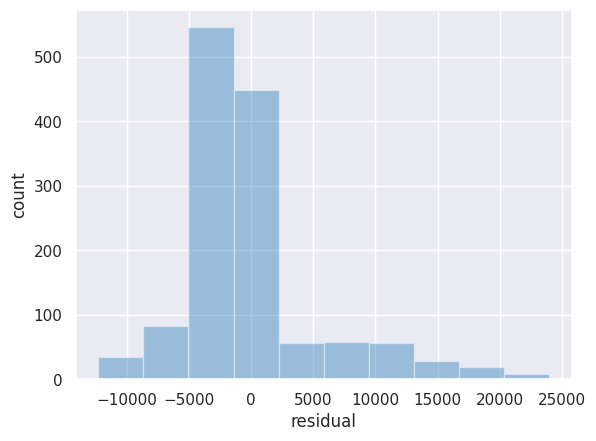

In [62]:
#Plot the distribution of the errors
plt.hist(lm1.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

## **Kesimpulan dan Saran/Rekomendasi:**
Setelah dilakukan analisis statistik, kita mendapatkan beberapa insight yang di mana dapat menjawab beberapa pertanyaan yang telah disebutkan sebelumnnya.

- Variabel manakah pada data yang mempunyai pengaruh terhadap terhadap tagihan kesehatan?
Berdasarkan hasil EDA yang telah dilakukan, bahwa terdapat 3 faktor yang yang dapat mempengaruhi tagihan kesehtan, yaitu : sex (jenis kelamin), smoker (status merokok),  dan age (umur) 

    1. **Faktor sex (jenis kelamin)**. Apabila seseorang berjenis kelamin laki-laki, maka ia memiliki kecenderungan yang lebih tinggi untuk mendapatkan tagihan kesehatan yang lebih besar dibandingkan seseorang berjenis kelamin perempuan
    
    2. **Faktor smoker (status merokok)**.  Apabila seseorang merokok, maka ia memiliki kecenderungan yang lebih tinggi untuk mendapatkan tagihan kesehtana yang lebih besar dibandingkan seseorang yang tidak merokok.
        
    3. **Faktor age (umur)**. umur memiliki korelasi dengan tagihan kesehatan sebesar 0,312
    
- Apakah variabel age mempunyai hubungan yang kuat dengan tagihan kesehatan?

    - Berdasarkan hasil EDA yang telah dilakukan, variabel age memiliki korelasi yang cukup kuat dengan tagihan kesehatan sebesar 0,312.

- Apakah variabel children mempunyai hubungan yang kuat dengan tagihan kesehatan?

  - Berdasarkan hasil EDA yang telah dilakukan, variabel children tidak memiliki korelasi yang cukup kuat dengan tagihan kesehatan. hal ini ditandai dengan nilai koefisien korelasi 0.25 < r < 0.5.

- Apakah variabel bmi mempunyai hubungan yang kuat dengan tagihan kesehatan?
   - Berdasarkan hasil EDA yang telah dilakukan, variabel bmi tidak memiliki korelasi yang cukup kuat dengan tagihan kesehatan. hal ini ditandai dengan nilai koefisien korelasi 0.25 < r < 0.5.

 
    
- Bagaimana kesimpulan akhirnya ? dan rekomendasi apakah yang dapat dilakukan?

    - Terdapat 3 faktor yang menjadi perhatian, yaitu sex (jenis kelamin), smoker (status merokok), dan age (umur). Faktor tersebut dapat mempengaruhi besar kecilnya tagihan kesehatan. 

    